<a href="https://colab.research.google.com/github/dhruvvaidh/Personal/blob/main/Detecting_pneumonia_using_chest_X_rays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import keras as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
"from keras.optimizers import Adam"
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
from mlxtend.plotting import plot_confusion_matrix

seed =232
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


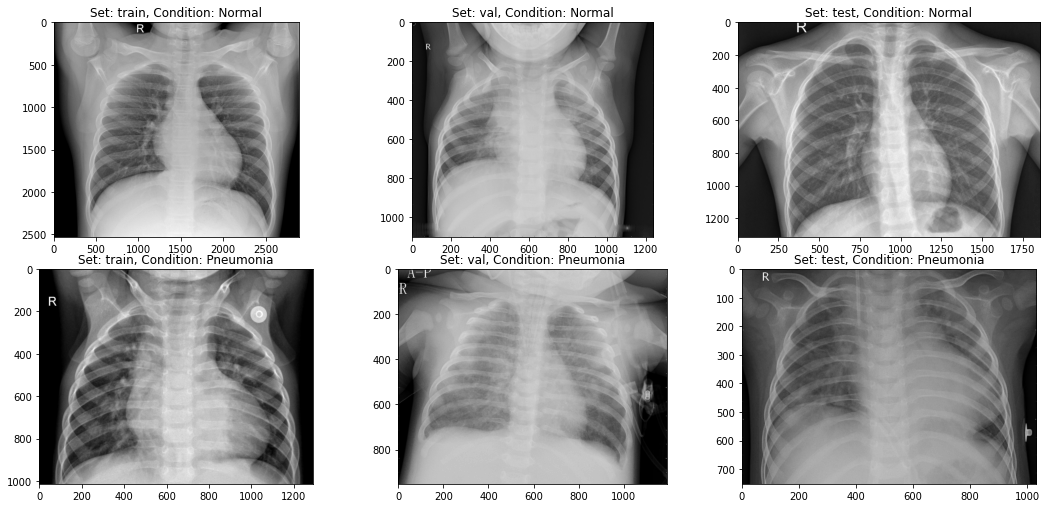

In [ ]:
input_path = "/content/drive/MyDrive/IP-Project/chest_xray/"

fig, ax = plt.subplots(2,3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path =input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]),cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]),cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

In [ ]:
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, normal images: 1341, pneumonia images: 3875
Set: val, normal images: 8, pneumonia images: 8
Set: test, normal images: 234, pneumonia images: 390


In [ ]:
def process_data(img_dims, batch_size):
    
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
    directory=input_path+'train',
    target_size=(img_dims, img_dims),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True)
    
    test_gen = test_val_datagen.flow_from_directory(
    directory=input_path+'test',
    target_size=(img_dims, img_dims),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True)
    
    # We will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []
    
    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + 'test' + cond)):
            img = plt.imread(input_path+'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float') / 255
            if cond=='/NORMAL/':
                label = 0;
            elif cond=='/PNEUMONIA/':
                label = 1;
            test_data.append(img)
            test_labels.append(label)
   
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

In [ ]:
img_dims = 150
epochs = 10
batch_size = 32

train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
inputs = Input(shape=(img_dims, img_dims, 3))

#First conv block
x = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2,2))(x)

#Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2))(x)

#Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2))(x)

#Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2))(x)
x = Dropout(rate=0.2)(x)

#Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2))(x)
x = Dropout(rate=0.2)(x)

#FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

#Output Layer
output = Dense(units = 1, activation='sigmoid')(x)

#Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 separable_conv2d (Separable  (None, 75, 75, 32)       688       
 Conv2D)                                                         
                                                                 
 separable_conv2d_1 (Separab  (None, 75, 75, 32)       1344  

In [ ]:
hist = model.fit_generator(
            train_gen, steps_per_epoch = train_gen.samples //batch_size,
            epochs=epochs, validation_data=test_gen,
            validation_steps=test_gen.samples //batch_size, callbacks=[checkpoint, lr_reduce])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/10
163/163 [==============================] - 1352s 8s/step - loss: 0.3845 - accuracy: 0.8240 - val_loss: 0.7017 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 290s 2s/step - loss: 0.2830 - accuracy: 0.8773 - val_loss: 0.7592 - val_accuracy: 0.6266 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - 285s 2s/step - loss: 0.2339 - accuracy: 0.9036 - val_loss: 1.0986 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 288s 2s/step - loss: 0.2069 - accuracy: 0.9220 - val_loss: 2.1894 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 5/10
163/163 [==============================] - 285s 2s/step - loss: 0.1888 - accuracy: 0.9293 - val_loss: 0.3877 - val_accuracy: 0.8306 - lr: 0.0010
Epoch 6/10
163/163 [==============================] - 290s 2s/step - loss: 0.1885 - accuracy: 0.9260 - val_loss: 2.2988 - val_accuracy: 0.6414 - lr: 0.0010
Epoch 7/10
163/163 [==============================] - 295s 2s/s

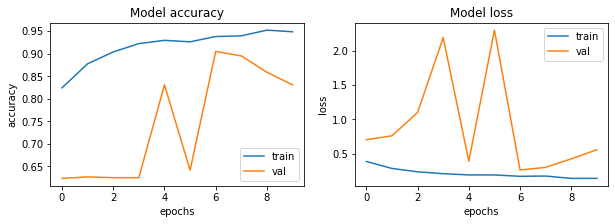

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

---------------CONFUSION MATRIX---------------


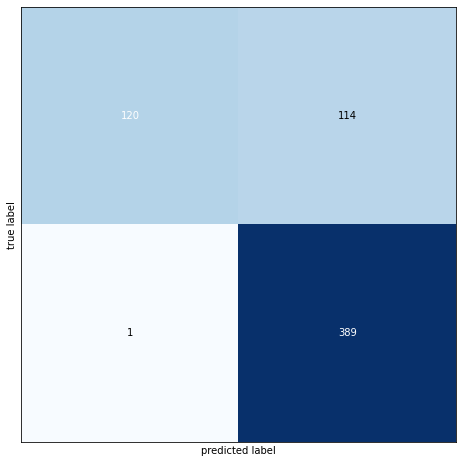


---------------TRAIN METRIC---------------
Train accuracy: 94.82

---------------TEST METRIC---------------
Accuracy: 81.57051282051282%
Precision: 77.33598409542743%
Recall: 99.74358974358975%
F1-score: 87.12206047032474


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

accuracy = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()


print('---------------CONFUSION MATRIX---------------')

fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(10,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.show()

print('\n---------------TRAIN METRIC---------------')
print('Train accuracy: {}'.format(np.round((hist.history['accuracy'][-1])*100,2)))

print('\n---------------TEST METRIC---------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(accuracy))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))